In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import seaborn as sns
import os
os.chdir("/content/drive/MyDrive/study/RStanBook/")

In [ ]:
df = pd.read_table("data/data-salary-2.txt", sep=',')
print(df.shape)
df.head()

(40, 3)


,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


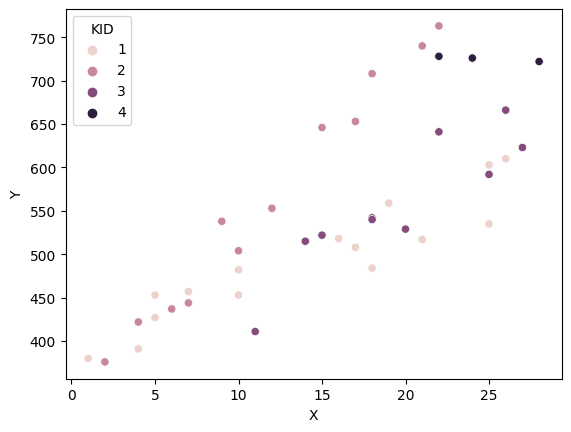

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x=df['X'], y=df['Y'], hue=df["KID"], ax=ax)
plt.show()

In [ ]:
model = pm.Model()
with model:
    X_data = pm.Data("X_data", df['X'], mutable=True)
    Y_data = pm.Data("Y_data", df['Y'], mutable=True)
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=100)
    mu = pm.Deterministic("mu", a+b*X_data)
    sigma = pm.HalfNormal("sigma", sigma=100)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)

with model:
    idata = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42)

# 会社全部で見ると、年齢が一つ上がるたびに年収が12.2上がる
display(az.summary(idata, var_names=['a', 'b', "sigma"]))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,354.516,25.033,306.048,399.809,0.687,0.486,1351.0,1362.0,1.0
b,12.182,1.450,9.614,15.123,0.041,0.029,1289.0,1294.0,1.0
sigma,68.793,8.251,54.196,83.987,0.191,0.137,1966.0,1953.0,1.0


In [ ]:
kid = pd.Categorical(df["KID"]).codes
c = np.array([10, 30, 20, 40])

c[kid]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 40, 40, 40])

In [ ]:
df_2 = df.query("KID==4")
df_2.head()

,X,Y,KID
37,28,722,4
38,24,726,4
39,22,728,4


In [ ]:
# 各社別々で回帰係数を考える
model2 = pm.Model()

with model2:
    X_data = pm.Data("X_data", df_2['X'], mutable=True)
    Y_data = pm.Data("Y_data", df_2['Y'], mutable=True)
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=100)
    mu = pm.Deterministic("mu", a+b*X_data)
    sigma = pm.HalfNormal("sigma", sigma=100)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)


with model2:
    idata2 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.995)

display(az.summary(idata2, var_names=['a', 'b', "sigma"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,30.486,100.464,-159.113,217.278,2.712,2.011,1379.0,1540.0,1.00
b,27.875,4.790,19.247,37.304,0.133,0.094,1308.0,1426.0,1.01
sigma,103.096,43.593,34.427,184.369,1.236,0.887,1328.0,1630.0,1.00


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


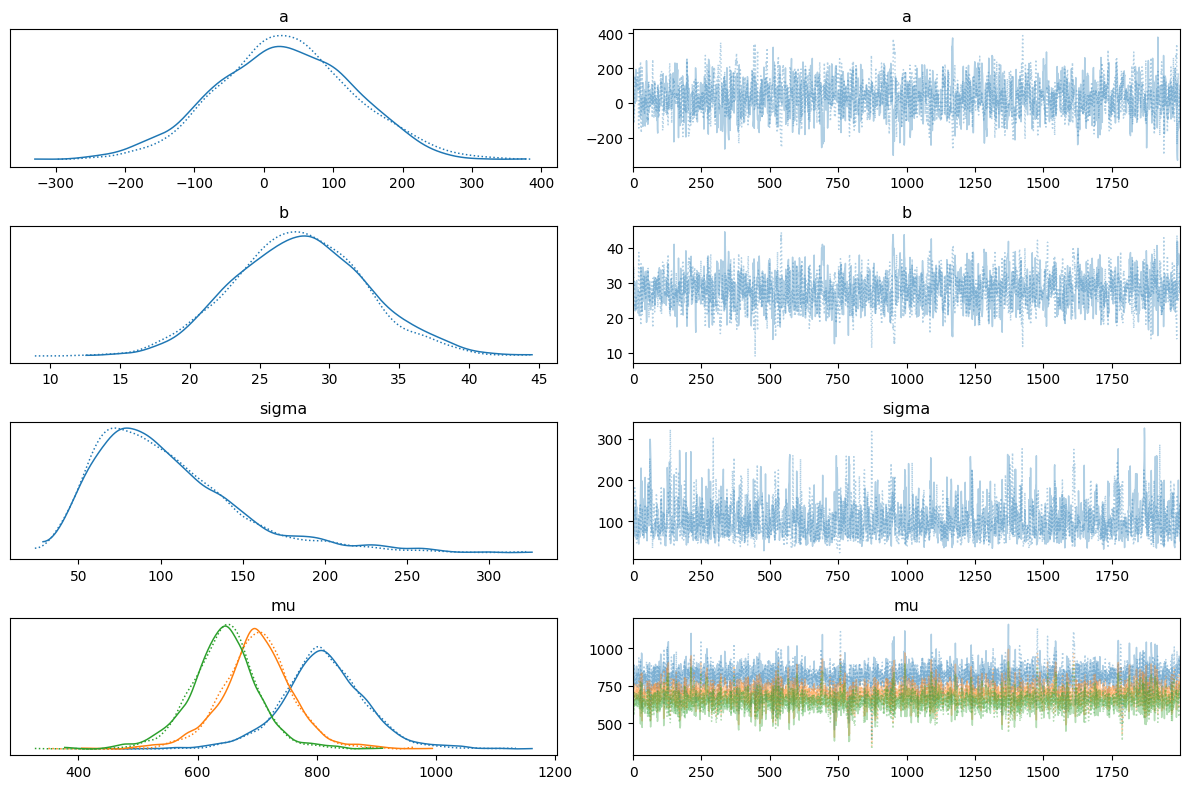

In [ ]:
az.plot_trace(idata2)
plt.tight_layout();

In [ ]:
# 各社個別の回帰係数を考える
model3 = pm.Model()
K = 4

with model3:
    X_data = pm.Data("X_data", df['X'], mutable=True)
    Y_data = pm.Data("Y_data", df['Y'], mutable=True)

    # 各社の回帰係数はalphaに従うと考える。
    # ただし、alphaには全社共通の平均a_muがあり、ノイズとしてa_sigmaがのって各社のalphaが生まれると考える
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=100.0)
    a_sigma = pm.HalfNormal("a_sigma", sigma=100.0)
    alpha = pm.Normal("alpha", mu=a_mu, sigma=a_sigma, shape=K)

    b_mu = pm.Normal("b_mu", mu=0.0, sigma=100.0)
    b_sigma = pm.HalfNormal("b_sigma", sigma=100.0)
    beta = pm.Normal("beta", mu=b_mu, sigma=b_sigma, shape=K)

    mu = pm.Deterministic("mu", alpha[kid]*X_data+beta[kid])
    sigma = pm.HalfNormal("sigma", sigma=100.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)

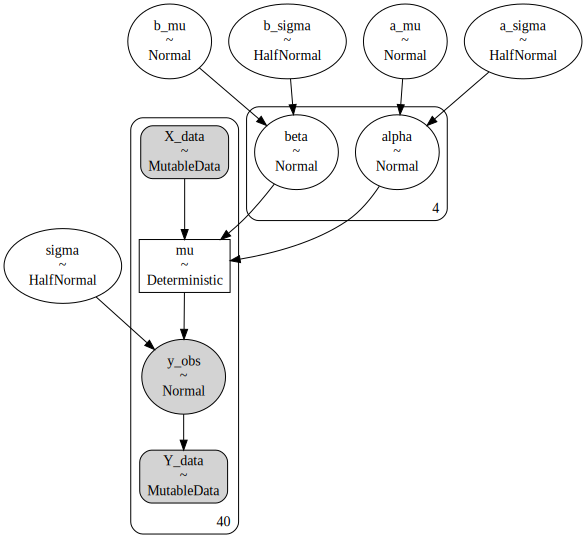

In [ ]:
pm.model_to_graphviz(model3)

In [ ]:
with model3:
    idata3 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.995)

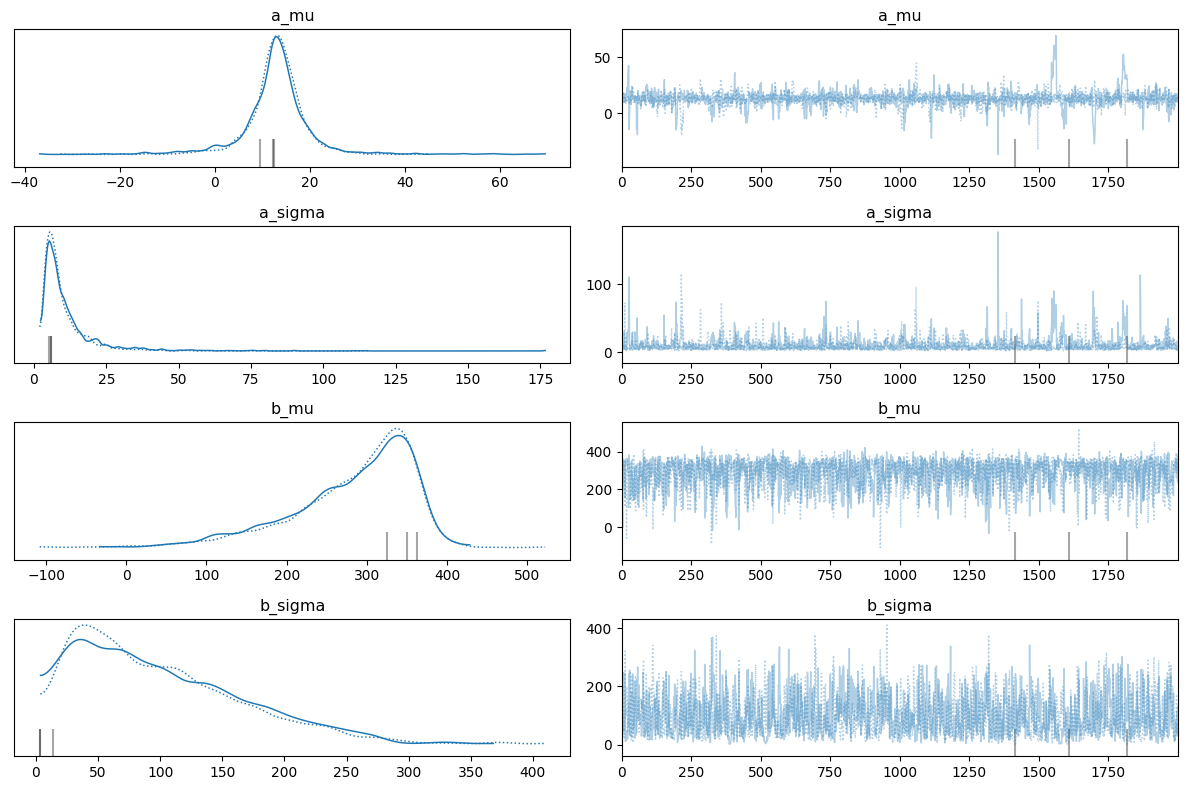

In [ ]:
az.plot_trace(idata3, var_names=["a_mu", "a_sigma", "b_mu", "b_sigma"])
plt.tight_layout();

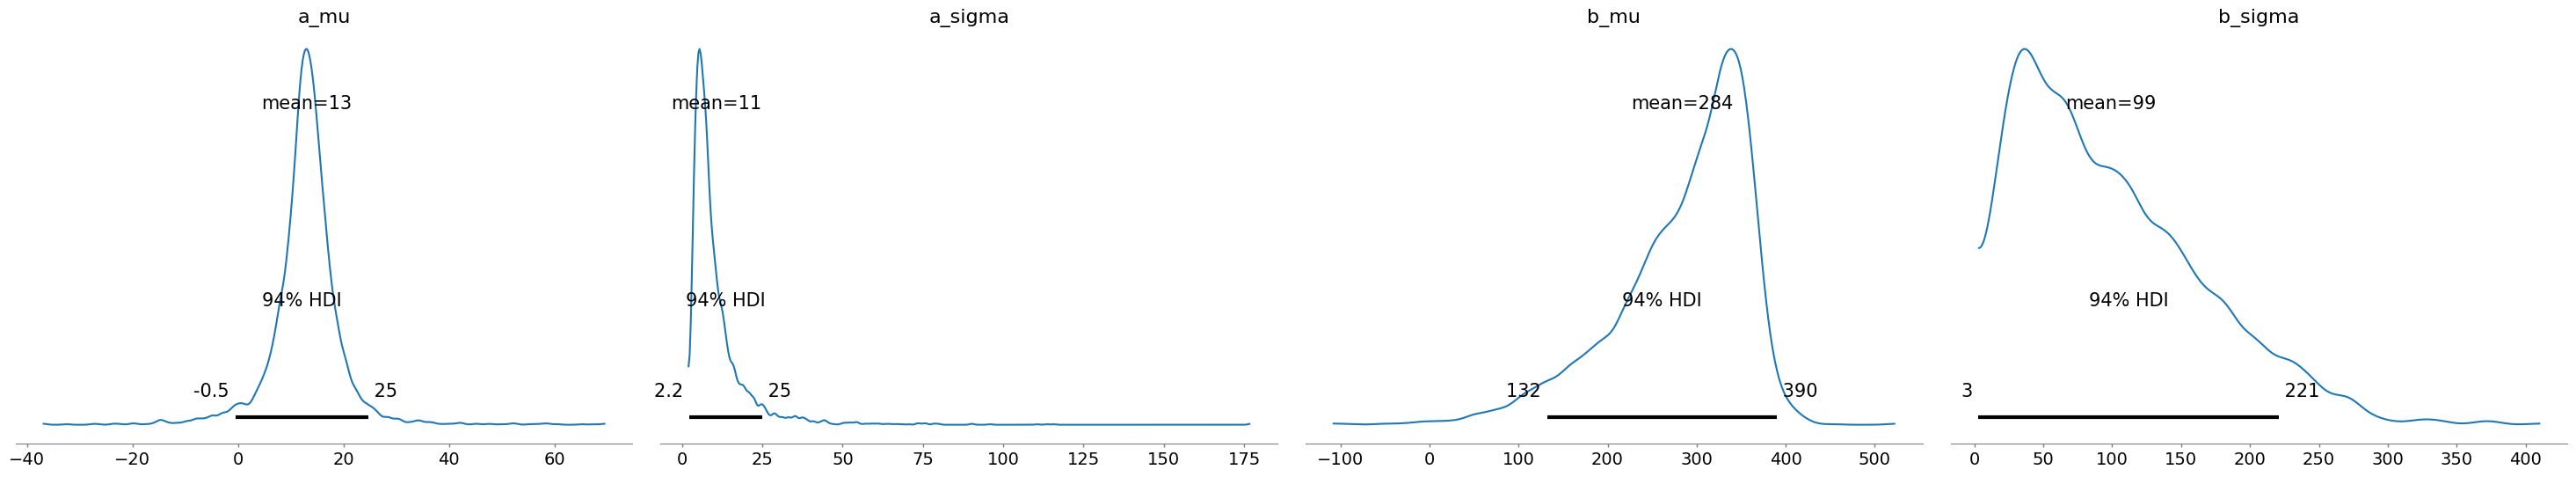

In [ ]:
az.plot_posterior(idata3, var_names=["a_mu", "a_sigma", "b_mu", "b_sigma"])
plt.tight_layout();

In [ ]:
az.summary(idata3, var_names=["a_mu", "a_sigma", "b_mu", "b_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,12.952,6.893,-0.500,24.769,0.296,0.255,892.0,704.0,1.01
a_sigma,10.581,9.939,2.180,24.917,0.343,0.242,1177.0,941.0,1.00
b_mu,284.076,74.750,131.894,390.409,1.913,1.372,1609.0,2103.0,1.00
b_sigma,99.136,66.707,3.030,220.925,1.951,1.380,975.0,1031.0,1.00


In [ ]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,12.952,6.893,-0.500,24.769,0.296,0.255,892.0,704.0,1.01
alpha[0],7.856,0.949,6.155,9.756,0.022,0.016,1863.0,1883.0,1.00
alpha[1],19.539,1.309,17.064,21.988,0.029,0.020,2098.0,2306.0,1.00
alpha[2],12.352,1.633,9.641,15.732,0.036,0.025,2116.0,2388.0,1.00
alpha[3],12.662,4.046,4.504,19.674,0.108,0.076,1586.0,1831.0,1.00
b_mu,284.076,74.750,131.894,390.409,1.913,1.372,1609.0,2103.0,1.00
beta[0],381.166,15.365,351.574,408.797,0.369,0.261,1769.0,1639.0,1.00
beta[1],332.532,17.596,300.621,366.879,0.384,0.272,2113.0,2049.0,1.00
beta[2],316.296,33.284,251.571,375.628,0.748,0.529,1991.0,2245.0,1.00
beta[3],409.826,99.813,253.404,622.770,2.689,1.941,1554.0,1797.0,1.00


In [ ]:
df4 = pd.read_table("data/data-salary-3.txt", sep=',')
df4.head()

,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


In [ ]:
print(df4.shape)
print(df4["GID"].nunique())
print(df4["KID"].nunique())

(300, 4)
3
30


In [ ]:
G = 3
gid = pd.Categorical(df4["GID"]).codes
kid = pd.Categorical(df4["KID"]).codes
k2g = {k:g for k, g in zip(df4["KID"], df4["GID"])}

In [ ]:
kid

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 20

In [ ]:
# 業界(GID)ごとに回帰係数と切片で共有する平均があるが、ノイズとして業界差が生まれると考える
model4 = pm.Model()
G = 3
K = 30
gid = pd.Categorical(df4["GID"]).codes
kid = pd.Categorical(df4["KID"]).codes
k2g = {k:g for k, g in zip(df4["KID"], df4["GID"])}

with model4:
    X_data = pm.Data("X_data", df4['X'], mutable=True)
    Y_data = pm.Data("Y_data", df4['Y'], mutable=True)

    a_g_mu = pm.Normal("a_g_mu", mu=0.0, sigma=100.0)
    a_g_sigma = pm.HalfNormal("a_g_sigma", sigma=100.0)
    alpha_g = pm.Normal("alpha_g", mu=a_g_mu, sigma=a_g_sigma, shape=G)
    a_k_sigma = pm.HalfNormal("a_k_sigma", sigma=100.0)
    alpha = pm.Normal("alpha", mu=alpha_g[gid], sigma=a_k_sigma,)

    b_g_mu = pm.Normal("b_g_mu", mu=0.0, sigma=100.0) # 業界の回帰係数の平均値
    b_g_sigma = pm.HalfNormal("b_g_sigma", sigma=100.0) # 業界の回帰係数のばらつき
    beta_g = pm.Normal("beta_g", mu=b_g_mu, sigma=b_g_sigma, shape=G)
    b_k_sigma = pm.HalfNormal("b_k_sigma", sigma=100.0)
    beta = pm.Normal("beta", mu=beta_g[gid], sigma=b_k_sigma,)

    mu = pm.Deterministic("mu", alpha[kid]+beta[kid]*X_data)
    sigma = pm.HalfNormal("sigma", sigma=100.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)

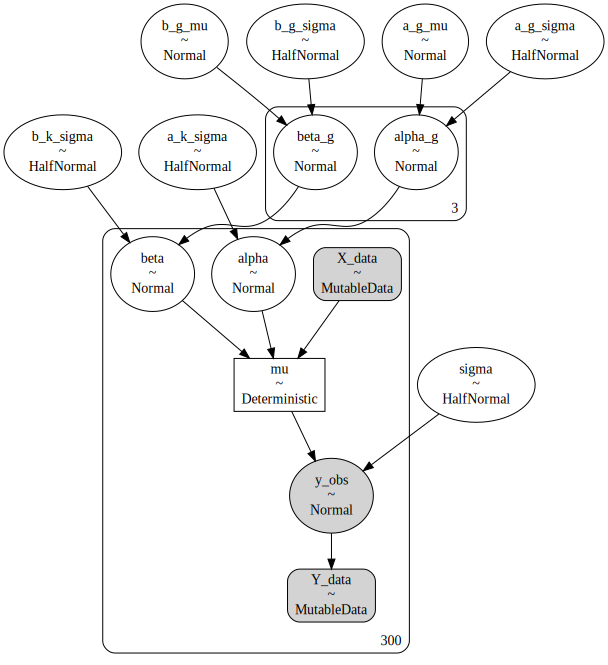

In [ ]:
pm.model_to_graphviz(model4)

In [ ]:
with model4:
    idata4 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.998)

In [ ]:
df5 = pd.read_table("data/data-conc-2.txt", sep=',')
print(df5.shape)
df5 = pd.melt(df5.set_index("PersonID"), ignore_index=False).reset_index()
df5["variable"] = df5["variable"].str.replace("Time", '').astype(int)
print(df5["variable"].unique())
pid = pd.Categorical(df5["PersonID"]).codes
df5.head()

(16, 7)
[ 1  2  4  8 12 24]


,PersonID,variable,value
0,1,1,2.4
1,2,1,1.4
2,3,1,5.2
3,4,1,6.7
4,5,1,0.3


In [ ]:
a = np.array([10,20,40,30])
b = np.array([1,2,4,3])
idx = np.array([0,0,0,1,1,2,2,3])
a[idx]*b[idx]

array([ 10,  10,  10,  40,  40, 160, 160,  90])

In [ ]:
model5 = pm.Model()
P = df5["PersonID"].nunique()

with model5:
    Y_data = pm.Data("Y_data", df5["value"], mutable=True)
    Time = pm.Data("Time", df5["variable"], mutable=True)

    # 各患者のaやbには共通の平均値があり、それを平均とした正規分布から各患者のalphaが生成される
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=100.0)
    a_sigma = pm.HalfNormal("a_sigma", sigma=100.0)
    alpha = pm.Normal("alpha", mu=a_mu, sigma=a_sigma, shape=P) # alphaは正の値をとる
    alpha_exp = pm.Deterministic("alpha_exp", pm.math.exp(alpha))

    b_mu = pm.Normal("b_mu", mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal("b_sigma", sigma=100.0)
    beta = pm.Normal("beta", mu=b_mu, sigma=b_sigma, shape=P)
    beta_exp = pm.Deterministic("beta_exp", pm.math.exp(beta))

    mu = pm.Deterministic( "mu", alpha_exp[pid]*(1-pm.math.exp(-beta_exp[pid]*Time[pid])) )
    sigma = pm.HalfNormal("sigma", sigma=100.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)

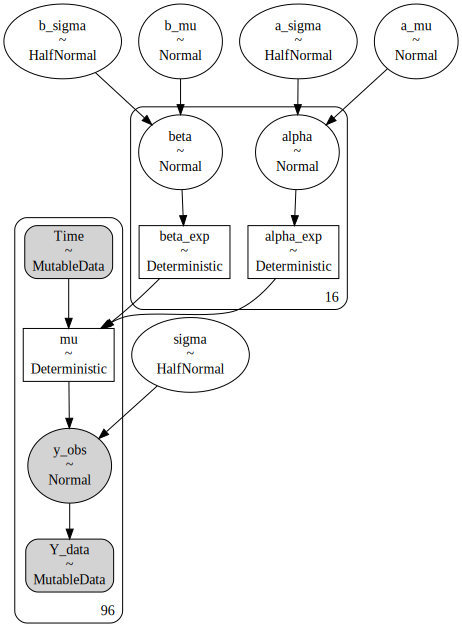

In [ ]:
pm.model_to_graphviz(model5)

In [ ]:
with model5:
    idata5 = pm.sample(draws=1000, tune=1000, chains=2, random_seed=1, target_accept=0.998)

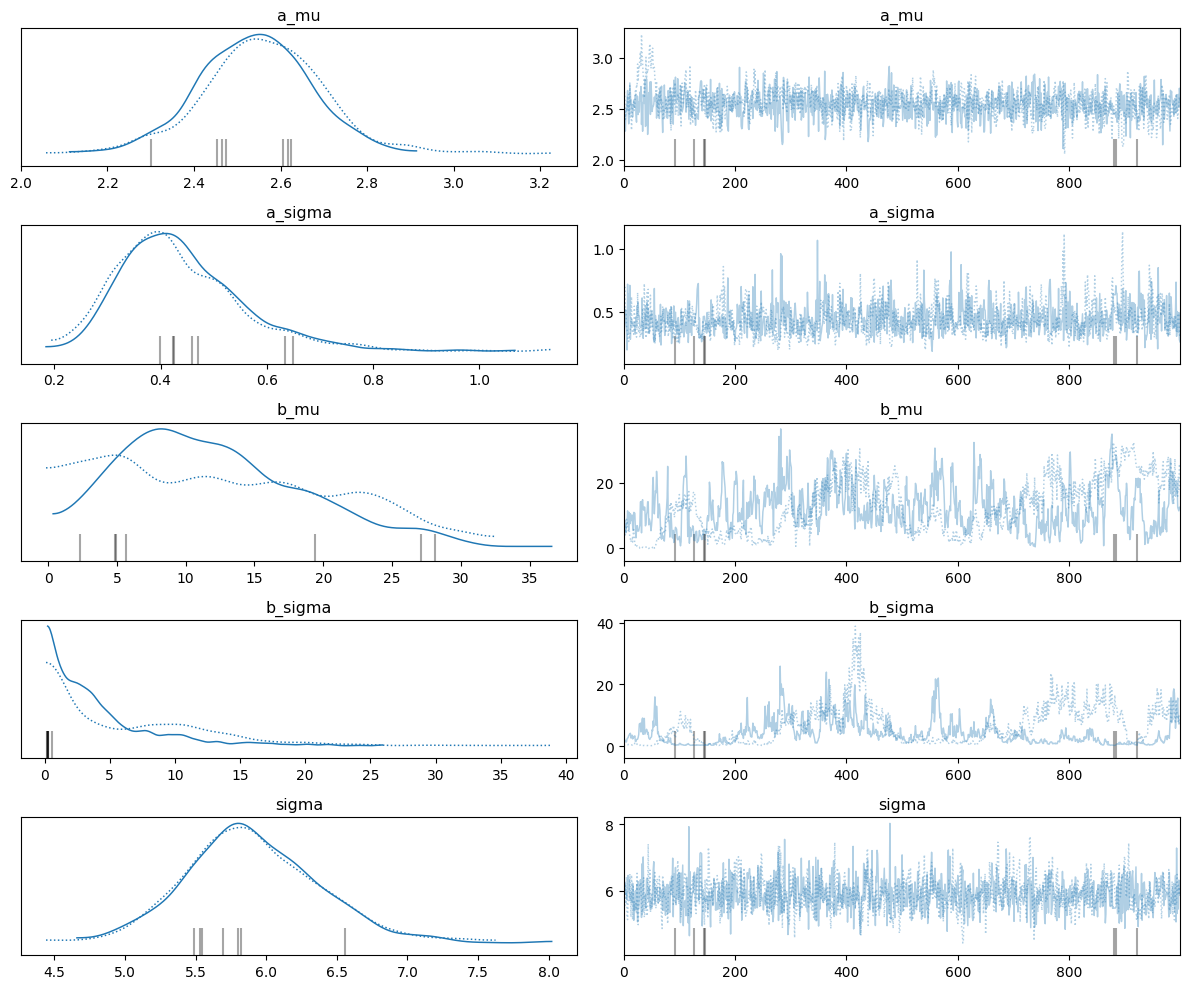

In [ ]:
az.plot_trace(idata5, var_names=["a_mu", "a_sigma", "b_mu", "b_sigma", "sigma"])
plt.tight_layout();

In [ ]:
az.summary(idata5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,2.551,0.137,2.279,2.791,0.008,0.006,324.0,204.0,1.02
alpha[0],2.238,0.241,1.799,2.676,0.012,0.009,404.0,378.0,1.01
alpha[1],2.027,0.341,1.351,2.626,0.032,0.025,147.0,91.0,1.03
alpha[2],2.784,0.164,2.467,3.081,0.007,0.005,643.0,340.0,1.00
alpha[3],2.892,0.144,2.626,3.152,0.007,0.005,527.0,226.0,1.01
...,...,...,...,...,...,...,...,...,...
mu[91],13.146,2.128,9.557,17.407,0.048,0.034,1939.0,1334.0,1.00
mu[92],8.422,2.072,4.763,12.437,0.065,0.046,1080.0,699.0,1.00
mu[93],15.949,2.324,11.629,20.166,0.065,0.046,1291.0,1212.0,1.00
mu[94],11.696,2.162,7.911,16.019,0.049,0.035,1908.0,1017.0,1.00


In [2]:
df6 = pd.read_table("data/data-attendance-4-1.txt", sep=',')
df6_2 = pd.read_table("data/data-attendance-4-2.txt", sep=',')
df6["Score"] = df6["Score"] / 200
df6_2["Weather"] = df6_2["Weather"].map({'A':0, 'B':0.2, 'C':1.0})
print(df6.shape)
display(df6.head())
print(df6_2.shape)
display(df6_2.head())

(50, 3)


,PersonID,A,Score
0,1,0,0.345
1,2,1,0.725
2,3,0,0.625
3,4,1,0.430
4,5,1,0.790


(2396, 4)


,PersonID,CourseID,Weather,Y
0,1,3,0.2,1
1,1,9,0.0,1
2,1,1,1.0,1
3,1,9,0.0,1
4,1,7,0.2,1


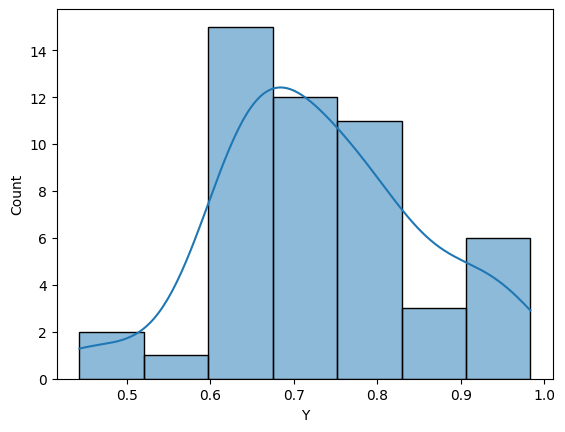

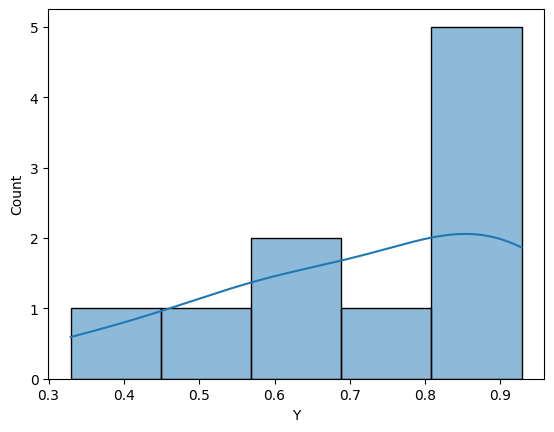

In [29]:
# 練習問題(4) 学生の出席率のヒストグラム
fig, ax = plt.subplots()
sns.histplot(df6_2.groupby("PersonID")['Y'].mean(), kde=True, ax=ax)
plt.show()

fig, ax = plt.subplots() # コース
sns.histplot(df6_2.groupby("CourseID")['Y'].mean(), kde=True, ax=ax)
plt.show()

In [48]:
pid = pd.Categorical(df6_2["PersonID"]).codes
N = df6["PersonID"].nunique()
cid = pd.Categorical(df6_2["CourseID"]).codes
C = df6_2["CourseID"].nunique()

model6 = pm.Model()

with model6:
    A_data = pm.Data("A_data", df6['A'], mutable=True)
    Score_data = pm.Data("Score_data", df6['Score'], mutable=True)
    Weather_data = pm.Data("Weather_data", df6_2["Weather"], mutable=True)
    Y_data = pm.Data("Y_data", df6_2['Y'], mutable=True)

    # 学生
    b2 = pm.Normal("b2", mu=0.0, sigma=100.0)
    b3 = pm.Normal("b3", mu=0.0, sigma=100.0)
    sigma_stu = pm.HalfNormal("sigma_stu", sigma=100.0)
    b_stu = pm.Normal("b_stu", mu=0.0, sigma=sigma_stu, shape=N)
    x_stu = pm.Deterministic("x_stu", b2*A_data+b3*Score_data+b_stu)

    # コース
    sigma_crs = pm.HalfNormal("sigma_crs", sigma=100.0)
    b_crs = pm.Normal("b_crs", mu=0.0, sigma=sigma_crs, shape=C)
    x_crs = pm.Deterministic("x_crs", b_crs)

    # 天気
    b4 = pm.Normal("b4", mu=0.0, sigma=100.0)
    x_wth = pm.Deterministic("x_wth", b4*Weather_data)

    b1 = pm.Normal("b1", mu=0.0, sigma=100.0)
    x = pm.Deterministic('x', b1+x_stu[pid]+x_crs[cid]+x_wth)
    q = pm.Deterministic('q', pm.math.invlogit(x))
    y_obs = pm.Bernoulli("y_obs", q, observed=Y_data)

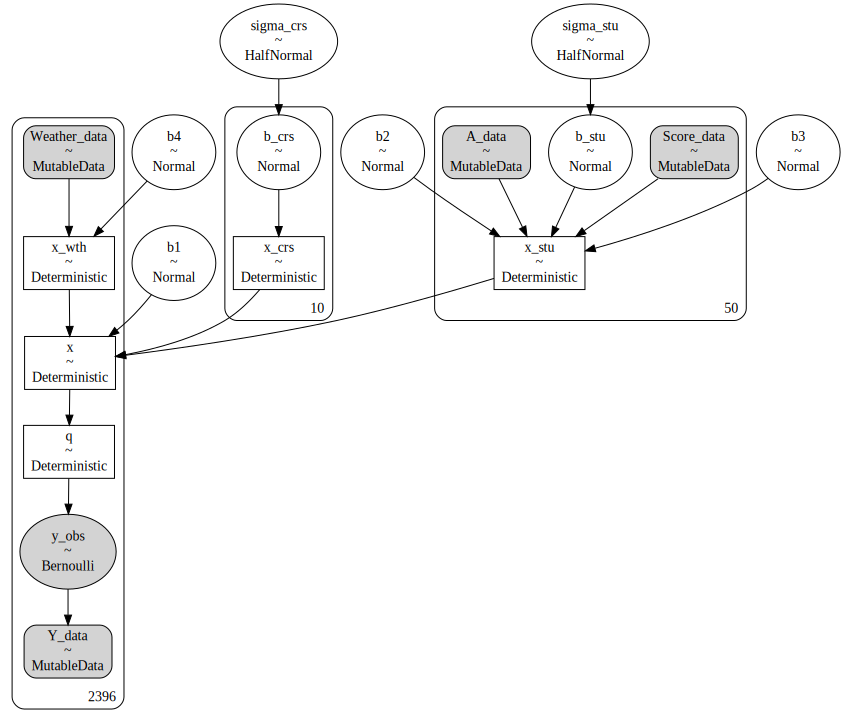

In [49]:
pm.model_to_graphviz(model6)

In [50]:
with model6:
    idata6 = pm.sample(draws=1000, tune=1000, chains=2, random_seed=42, target_accept=0.998)

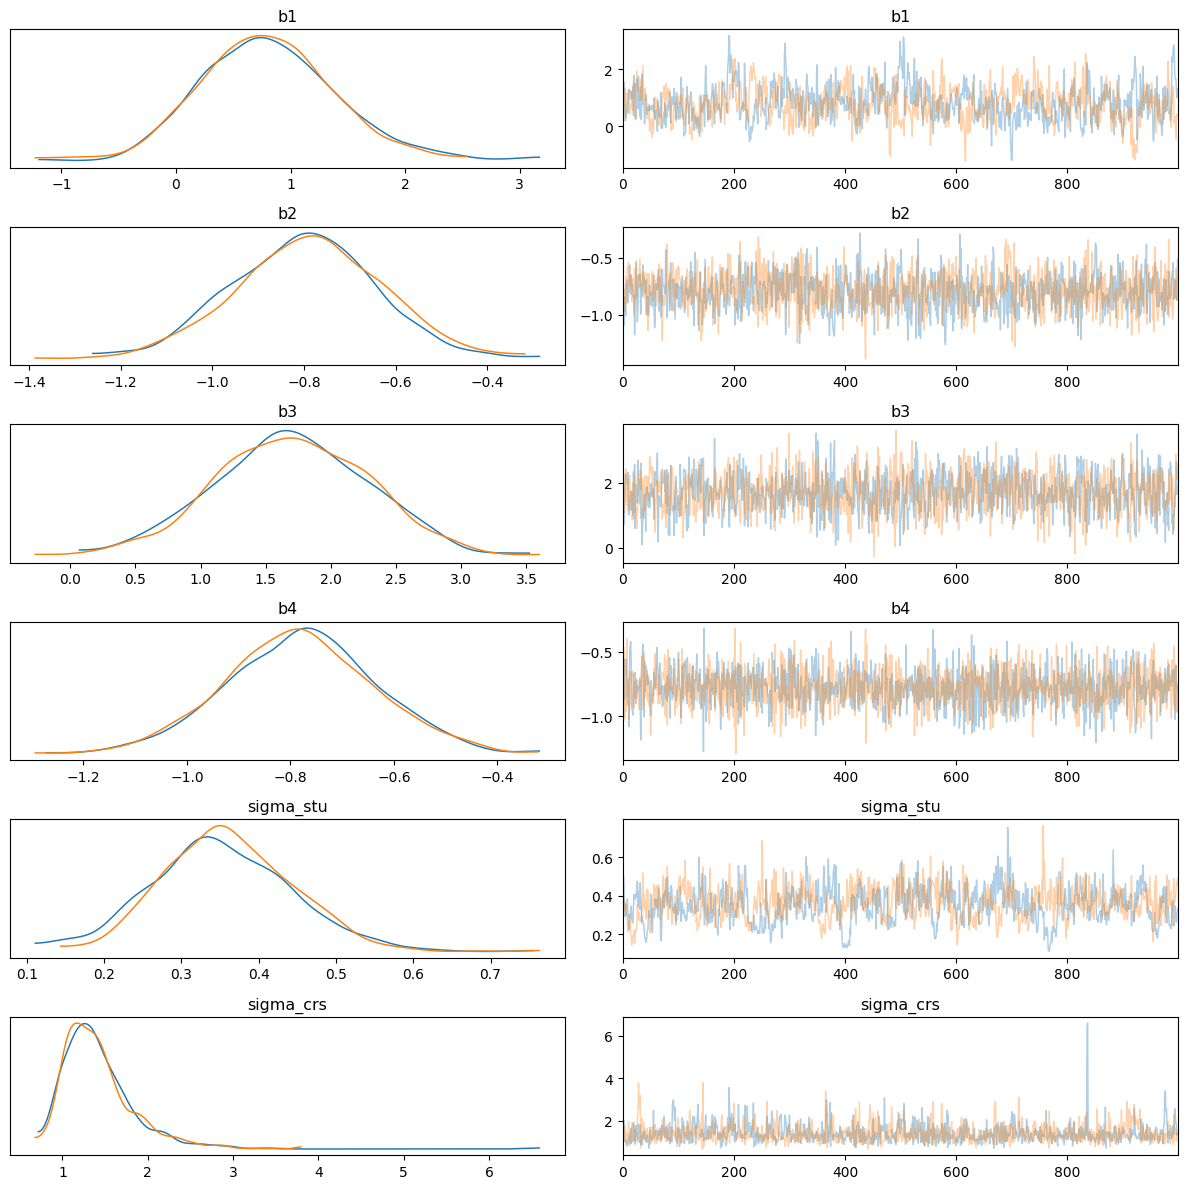

In [51]:
az.plot_trace(idata6, var_names=["b1", "b2", "b3", "b4", "sigma_stu", "sigma_crs"], compact=False)
plt.tight_layout();

In [52]:
az.summary(idata6, var_names=["b1", "b2", "b3", "b4", "sigma_stu", "sigma_crs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,0.804,0.604,-0.295,1.938,0.041,0.029,224.0,404.0,1.00
b2,-0.795,0.159,-1.096,-0.505,0.005,0.003,1191.0,1305.0,1.00
b3,1.698,0.591,0.585,2.813,0.017,0.012,1263.0,1228.0,1.00
b4,-0.782,0.144,-1.050,-0.505,0.003,0.002,2231.0,1533.0,1.00
sigma_stu,0.356,0.087,0.209,0.527,0.006,0.004,235.0,250.0,1.01
sigma_crs,1.422,0.444,0.792,2.229,0.015,0.011,943.0,1011.0,1.00


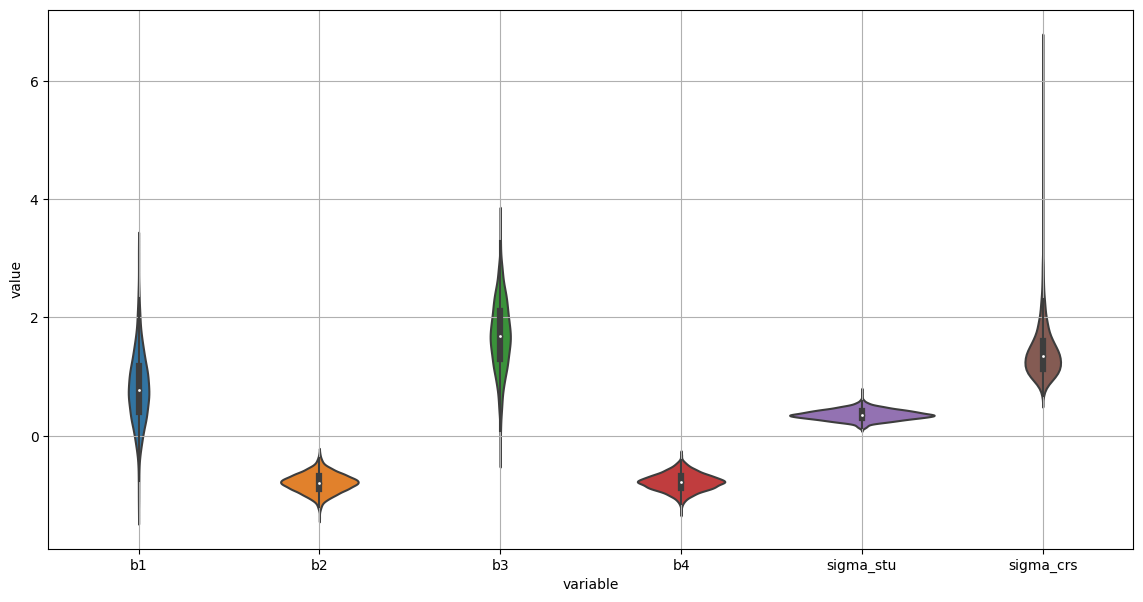

In [53]:
var_names=["b1", "b2", "b3", "b4", "sigma_stu", "sigma_crs"]
data = pd.DataFrame()
for v in var_names:
    data[v] = idata6["posterior"][v].to_numpy().reshape(-1, ).tolist()

fig, ax = plt.subplots(figsize=(14, 7))
sns.violinplot(pd.melt(data), x="variable", y="value", ax=ax)
plt.grid()
plt.show()

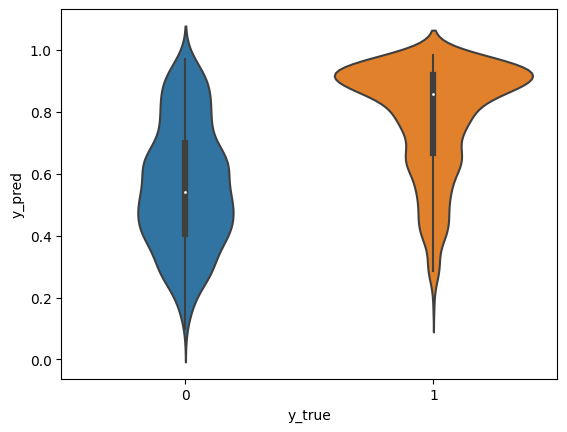

In [54]:
# 出席確率の事後分布からのサンプリングの中央値を使う
y_pred = np.quantile(idata6["posterior"]["q"].to_numpy().reshape(-1, len(df6_2)), 0.50, axis=0)
results = pd.DataFrame({"y_true":df6_2['Y'], "y_pred":y_pred})
fig, ax = plt.subplots()
sns.violinplot(results, x="y_true", y="y_pred", ax=ax)
plt.show()

In [55]:
model7 = pm.Model()

with model7:
    A_data = pm.Data("A_data", df6['A'], mutable=True)
    Score_data = pm.Data("Score_data", df6['Score'], mutable=True)
    Weather_data = pm.Data("Weather_data", df6_2["Weather"], mutable=True)
    Y_data = pm.Data("Y_data", df6_2['Y'], mutable=True)

    # 学生
    b2 = pm.Normal("b2", mu=0.0, sigma=100.0)
    b3 = pm.Normal("b3", mu=0.0, sigma=100.0)
    b_stu = pm.Normal("b_stu", mu=0.0, sigma=100.0, shape=N)# 無情報事前分布から学生差が生成されると考える
    x_stu = pm.Deterministic("x_stu", b2*A_data+b3*Score_data+b_stu)

    # コース
    b_crs = pm.Normal("b_crs", mu=0.0, sigma=100.0, shape=C) # 無情報事前分布からコース差が生成されると考える
    x_crs = pm.Deterministic("x_crs", b_crs)

    # 天気
    b4 = pm.Normal("b4", mu=0.0, sigma=100.0)
    x_wth = pm.Deterministic("x_wth", b4*Weather_data)

    b1 = pm.Normal("b1", mu=0.0, sigma=100.0)
    x = pm.Deterministic('x', b1+x_stu[pid]+x_crs[cid]+x_wth)
    q = pm.math.invlogit(x)
    y_obs = pm.Bernoulli("y_obs", q, observed=Y_data)


with model7:
    idata7 = pm.sample(draws=1000, tune=1000, chains=2, random_seed=42, target_accept=0.998)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (64), generating only 20 plots
  warnings.warn(


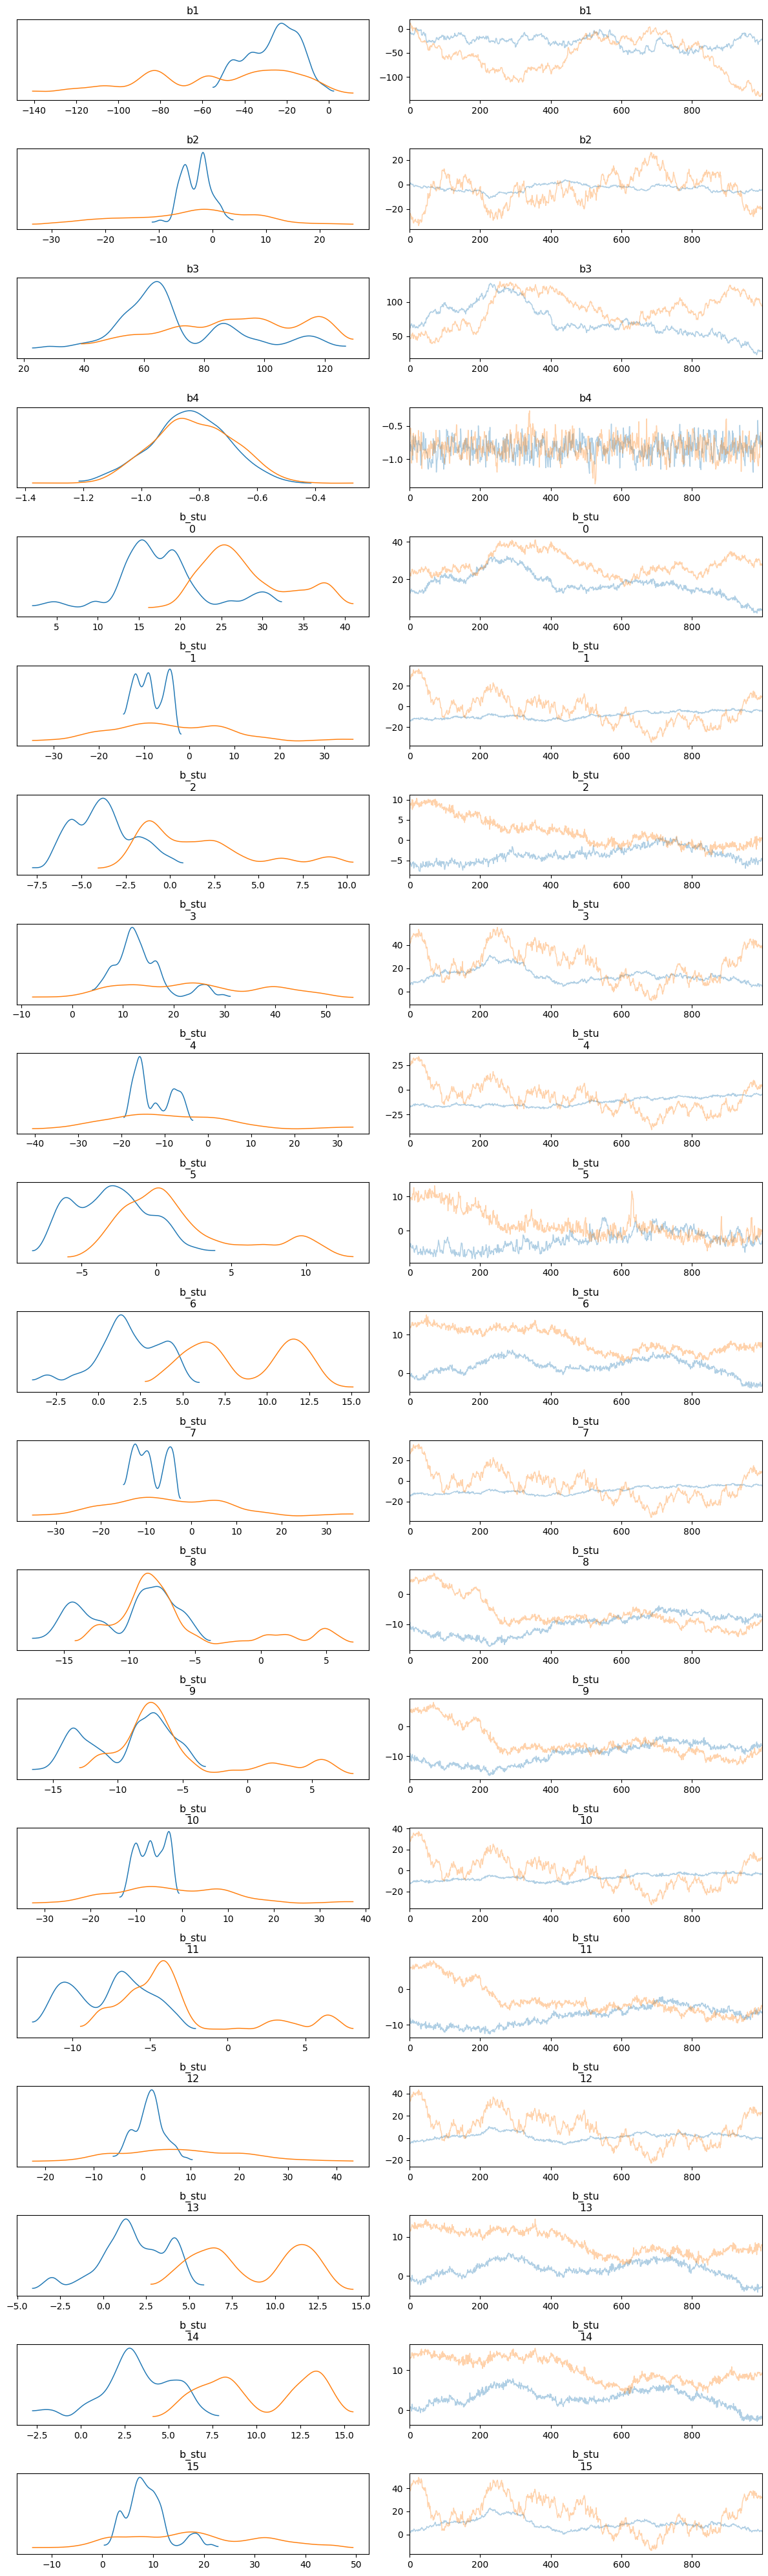

In [57]:
az.plot_trace(idata7, var_names=["b1", "b2", "b3", "b4", "b_stu", "b_crs"], compact=False)
plt.tight_layout();

In [2]:
df8 = pd.read_csv("data/data7a.csv")
print(df8.shape)
print(df8["id"].unique())
df8.head()

(100, 2)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


In [4]:
N = len(df8)
model8 = pm.Model()

with model8:
    Y_data = pm.Data("Y_data", df8['y'], mutable=True)

    b = pm.Normal('b', mu=0.0, sigma=100.0)
    sigma = pm.HalfNormal("sigma", sigma=100.0)
    b_y = pm.Normal("b_y", mu=0.0, sigma=sigma, shape=N)
    p = pm.Deterministic('p', pm.math.invlogit(b+b_y))
    y_obs = pm.Binomial("y_obs", n=8, p=p, observed=Y_data)

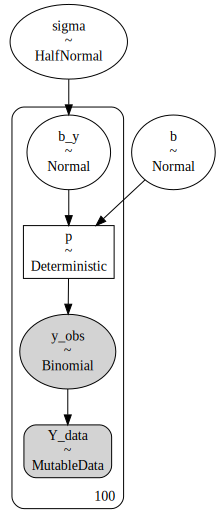

In [5]:
pm.model_to_graphviz(model8)

In [6]:
with model8:
    idata8 = pm.sample(draws=1000, tune=1000, chains=2, random_seed=42, target_accept=0.99)

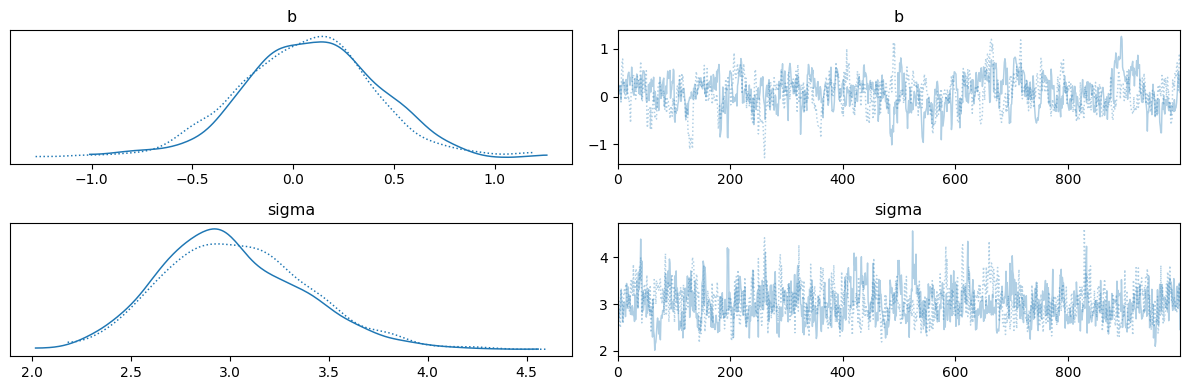

In [8]:
az.plot_trace(idata8, var_names=["b", "sigma"])
plt.tight_layout();

In [9]:
az.summary(idata8)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.074,0.339,-0.542,0.716,0.023,0.016,217.0,354.0,1.01
b_y[0],-3.930,1.823,-7.167,-0.698,0.059,0.046,1156.0,824.0,1.00
b_y[1],-1.213,0.849,-2.884,0.301,0.028,0.020,896.0,1339.0,1.00
b_y[2],1.996,1.131,-0.125,4.114,0.035,0.026,1072.0,1129.0,1.00
b_y[3],3.751,1.772,0.814,7.078,0.051,0.041,1484.0,1094.0,1.00
...,...,...,...,...,...,...,...,...,...
p[95],0.152,0.106,0.001,0.349,0.002,0.001,2428.0,1417.0,1.00
p[96],0.054,0.069,0.000,0.188,0.001,0.001,1638.0,1126.0,1.00
p[97],0.499,0.165,0.208,0.815,0.003,0.002,2372.0,1352.0,1.00
p[98],0.841,0.118,0.626,0.999,0.002,0.002,2128.0,1313.0,1.00


In [16]:
df9 = pd.read_csv("data/d1.csv")
df9['f'] = df9['f'].apply(lambda x:1 if x=='C' else 0)
print(df9.shape)
print(df9["pot"].unique())
print(df9["f"].unique())
df9.head()

(100, 4)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
[1 0]


,id,pot,f,y
0,1,A,1,6
1,2,A,1,3
2,3,A,1,19
3,4,A,1,5
4,5,A,1,0


In [18]:
P = df9["pot"].nunique()
pid = pd.Categorical(df9["pot"]).codes
I = df9["id"].nunique()
id = pd.Categorical(df9["id"]).codes
model9 = pm.Model()

with model9:
    Y_data = pm.Data("Y_data", df9['y'], mutable=True)
    f_data = pm.Data("f_data", df9['f'], mutable=True)
    # 個体差
    id_sigma = pm.HalfNormal("id_sigma", sigma=100.0)
    i = pm.Normal('i', mu=0.0, sigma=id_sigma, shape=I)
    # pot差
    pot_sigma = pm.HalfNormal("pot_sigma", sigma=100.0)
    p = pm.Normal('p', mu=0.0, sigma=pot_sigma, shape=P)
    b1 = pm.Normal("b1", mu=0.0, sigma=100.0)
    b2 = pm.Normal("b2", mu=0.0, sigma=100.0)
    mu = pm.Deterministic("mu", pm.math.exp(b1 + b2*f_data + p[pid] + i[id]))

    y_obs = pm.Poisson("y_obs", mu=mu, observed=Y_data)

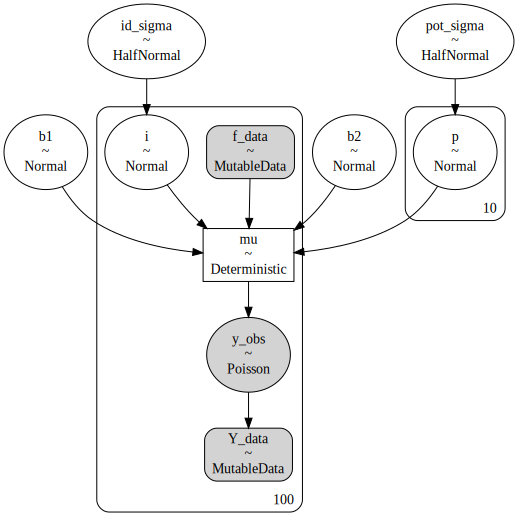

In [20]:
pm.model_to_graphviz(model9)

In [21]:
with model9:
    idata9 = pm.sample(draws=1000, tune=1000, chains=2, random_seed=42, target_accept=0.99)

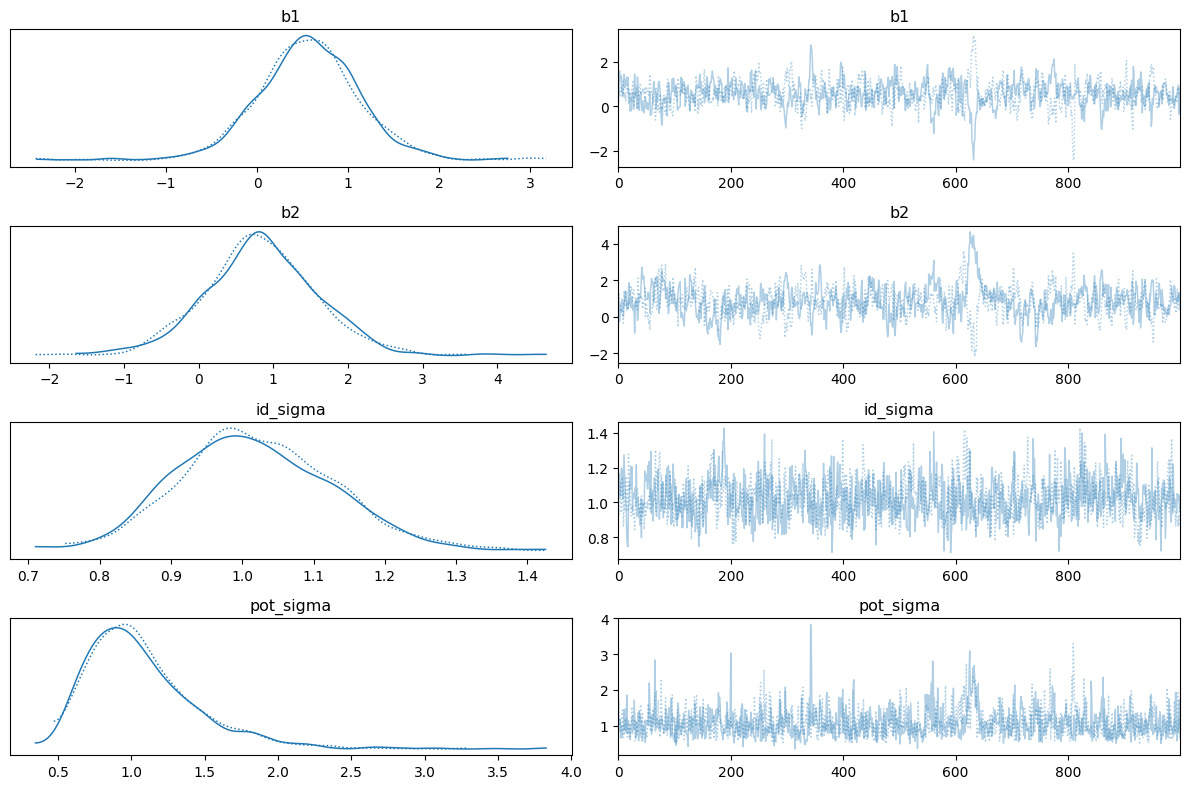

In [22]:
az.plot_trace(idata9, var_names=["b1", "b2", "id_sigma", "pot_sigma"])
plt.tight_layout();

In [23]:
az.summary(idata9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
i[0],-0.096,0.504,-1.134,0.757,0.020,0.014,674.0,1244.0,1.0
i[1],-0.641,0.547,-1.618,0.405,0.020,0.014,732.0,1089.0,1.0
i[2],1.042,0.398,0.369,1.857,0.022,0.015,332.0,1025.0,1.0
i[3],-0.248,0.511,-1.235,0.662,0.018,0.013,779.0,1224.0,1.0
i[4],-1.613,0.712,-2.985,-0.358,0.023,0.017,1017.0,1179.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[95],1.315,0.883,0.155,2.935,0.018,0.014,2060.0,1150.0,1.0
mu[96],1.303,0.922,0.089,3.000,0.018,0.014,2540.0,1430.0,1.0
mu[97],1.856,1.101,0.310,3.852,0.019,0.015,2852.0,1427.0,1.0
mu[98],1.287,0.890,0.063,2.936,0.018,0.013,2279.0,1607.0,1.0
